In [2]:
import torch
from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Data
import statistics

In [3]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

In [4]:
import warnings
warnings.filterwarnings("ignore")

### Data preprocessing

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.nn.functional import normalize

In [6]:
edges_df = pd.read_excel(r'~/Downloads/Traffic Speed Prediction Street View Images/Adjacent_Matrix.xls')
target = list(edges_df['TARGET_FID'])
join = list(edges_df['JOIN_FID'])
edge = torch.tensor([target, join], dtype=torch.long)

In [7]:
features_df = pd.read_csv(r'~/Downloads/Traffic Speed Prediction Street View Images/Features.csv')
feature_list = []
for i in range(features_df.shape[0]):
    feature = list(features_df.iloc[i][2: 367])
    feature_list.append(feature)
X_Image = torch.as_tensor(feature_list)

In [8]:
#Create traffic speed for each hour
speed_df = pd.read_csv(r'~/Downloads/Traffic Speed Prediction Street View Images/Y_2.csv')
speed_list = []
for i in range(speed_df.shape[0]):
    speed = list(speed_df.iloc[i][5:29])
    speed_list.append(speed)
Y = torch.as_tensor(speed_list)
X_Speed = Y[:, :12]
Y = Y[:, 12:].float()

In [9]:
network = Data(x=X_Image, y=Y, edge_index=edge)

In [10]:
Mask_df = pd.read_csv(r'~/Downloads/Traffic Speed Prediction Street View Images/Y_2.csv')
Train_Mask_list = list(Mask_df['Train_Mask'])
Train_Mask = torch.as_tensor(Train_Mask_list)

Val_Mask_list = list(Mask_df['Validation_Mask'])
Val_Mask = torch.as_tensor(Val_Mask_list)

Test_Mask_list = list(Mask_df['Test_Mask'])
Test_Mask = torch.as_tensor(Test_Mask_list)

In [11]:
# Dataset is:
### network: contains graph and scene features for each road node, y is speed of 12-11pm
### X_Speed: speed of 0-11am

In [12]:
X_Speed = X_Speed[:, :, None]
print(X_Speed.shape)
print(network.y.shape)

torch.Size([4698, 12, 1])
torch.Size([4698, 12])


### Prepare Dataset

In [13]:
from torch.utils.data import Dataset

In [14]:
class TrafficSpeedDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data = data_list
        self.transform = transform
        self.x
        self.y
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        x
        y
        return x, y

In [15]:
training_dataloader = None
test_dataloader = None

### Network Construction

In [16]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch import nn
import os
import random

In [17]:
class Net(torch.nn.Module):
    def __init__(self, time_number):
        super(Net, self).__init__()
        self.time_number = time_number
        self.num_layers = 4
        
        #graph part
        self.conv1 = GCNConv(365, 64)
        self.conv2 = GCNConv(64, 24)
        self.conv3 = GCNConv(24, 12)
        
        self.conv4 = GCNConv(24, 64)
        self.conv5 = GCNConv(64, 24)
        self.conv6 = GCNConv(24, 12)
        
        #Lstm part
        self.lstm = nn.LSTM(
            input_size = 1,
            hidden_size = 12,
            num_layers = self.num_layers,
            batch_first = True
        )
        
    
    def forward(self, graph, time_data):
        x, edge_index = graph.x, graph.edge_index
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)

        
        h0 = torch.zeros(self.num_layers, 4698, 12).requires_grad_().float().to(device)
        c0 = torch.zeros(self.num_layers, 4698, 12).requires_grad_().float().to(device)
        
        _, (hn, _) = self.lstm(time_data, (h0, c0))
        
        x_new = torch.cat((x, hn[3]), -1)

        x_new = self.conv4(x_new, edge_index)
        x_new = F.relu(x_new)
        x_new = F.dropout(x_new, training=self.training)
        
        x_new = self.conv5(x_new, edge_index)
        x_new = F.relu(x_new)
        x_new = F.dropout(x_new, training=self.training)
        
        x_new = self.conv6(x_new, edge_index)
        
        return x_new
        
        
        

In [39]:
class Net_LSTM(torch.nn.Module):
    def __init__(self, time_number):
        super(Net_LSTM, self).__init__()
        self.time_number = time_number
        self.num_layers = 4
        
        #graph part
        self.conv1 = GCNConv(12, 64)
        self.conv2 = GCNConv(64, 24)
        self.conv3 = GCNConv(24, 12)
        
        #Lstm part
        self.lstm = nn.LSTM(
            input_size = 1,
            hidden_size = 12,
            num_layers = self.num_layers,
            batch_first = True
        )
        
    
    def forward(self, graph, time_data):
        
        x, edge_index = graph.x, graph.edge_index
        
        h0 = torch.zeros(self.num_layers, 4698, 12).requires_grad_().float().to(device)
        c0 = torch.zeros(self.num_layers, 4698, 12).requires_grad_().float().to(device)
        
        _, (hn, _) = self.lstm(time_data, (h0, c0))
        
#         x_new = torch.cat((x, hn[3]), -1)
        x_new = hn[3]

        x_new = self.conv1(x_new, edge_index)
        x_new = F.relu(x_new)
        x_new = F.dropout(x_new, training=self.training)
        
        x_new = self.conv2(x_new, edge_index)
        x_new = F.relu(x_new)
        x_new = F.dropout(x_new, training=self.training)
        
        x_new = self.conv3(x_new, edge_index)
        
        return x_new
        
        
        

### Training process

In [40]:
Train_Val_M = []
True_list = []
for i in range(len(Train_Mask_list)):
    mask = Train_Mask_list[i] or Val_Mask_list[i]
    if mask:
        True_list.append(i)
    Train_Val_M.append(mask)

In [41]:
def my_loss(predict, real):
#     print(predict.shape)
    loss = torch.mean(torch.sqrt((predict - real)**2)/real)
    return loss

In [67]:
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GCNConv
from sklearn import metrics
from math import sqrt
import random
device = torch.device('cuda')

model = Net(time_number=12)
model.to(device)

learning_rate = 0.001
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
X_Speed = X_Speed.float().to(device)
network.to(device)
# Training
# eva = 'rmse'
# k_folder_Train(10, 300, True_list,network,X_Speed, eva)
epoch = 2000
val_loss_list = []
train_loss_list = []

val_loss_list_rmse = []
train_loss_list_rmse = []

model_loss = 1000000

for e in range(epoch):
    out = model(network, X_Speed)[:, :]
    y = network.y[:, :]
    optimizer.zero_grad()  
#     print(out-y)
    loss = torch.sqrt(loss_function(out[Train_Mask], y[Train_Mask]).float())
#     loss = my_loss(out[Train_Mask], y[Train_Mask]).float()
#     print(loss)
    
    loss.backward()
    optimizer.step()
    
#     loss_val = loss_function(out[Val_Mask], y[Val_Mask])
    loss_val = my_loss(out[Val_Mask], y[Val_Mask])
    loss_train = my_loss(out[Train_Mask], y[Train_Mask])
    
    loss_train_rmse = torch.sqrt(loss_function(out[Train_Mask], y[Train_Mask]).float())
    loss_val_rmse = torch.sqrt(loss_function(out[Val_Mask], y[Val_Mask].float()))
    
#     print('training error is: ', loss)
    val_loss_list.append(loss_val.cpu().detach().numpy())
    train_loss_list.append(loss_train.cpu().detach().numpy())
    
    val_loss_list_rmse.append(loss_val_rmse.cpu().detach().numpy())
    train_loss_list_rmse.append(loss_train_rmse.cpu().detach().numpy())
    
    if loss_val.cpu().detach().numpy() < model_loss:
        model_loss = loss_val.cpu().detach().numpy()
        name = 'model_best.pt'
        save_path = os.path.join(r'./Model_Weights', name)
        torch.save(model.state_dict(), save_path)
    if e%500 == 0:
        name = 'model_e' + str(e) + '.pt'
        save_path = os.path.join(r'./Models', name)
        torch.save(model.state_dict(), save_path)
        
    print("*****************************************************************")
    print('Epoch: ', e, '    train_loss_percentage:', loss_train.cpu().detach().numpy(), ';    ', 'val_loss_percentage:', loss_val.cpu().detach().numpy())
#     print('val_loss_percentage:', loss_val.cpu().detach().numpy())

*****************************************************************
Epoch:  0     train_loss_percentage: 1.0005674 ;     val_loss_percentage: 1.0005417
*****************************************************************
Epoch:  1     train_loss_percentage: 1.0004437 ;     val_loss_percentage: 1.0004411
*****************************************************************
Epoch:  2     train_loss_percentage: 1.0003196 ;     val_loss_percentage: 1.0003066
*****************************************************************
Epoch:  3     train_loss_percentage: 1.0002393 ;     val_loss_percentage: 1.0002244
*****************************************************************
Epoch:  4     train_loss_percentage: 1.0001308 ;     val_loss_percentage: 1.0001233
*****************************************************************
Epoch:  5     train_loss_percentage: 1.000013 ;     val_loss_percentage: 0.99999785
*****************************************************************
Epoch:  6     train_loss_percentag

*****************************************************************
Epoch:  64     train_loss_percentage: 0.9011914 ;     val_loss_percentage: 0.90650976
*****************************************************************
Epoch:  65     train_loss_percentage: 0.89355963 ;     val_loss_percentage: 0.8967771
*****************************************************************
Epoch:  66     train_loss_percentage: 0.880765 ;     val_loss_percentage: 0.8854073
*****************************************************************
Epoch:  67     train_loss_percentage: 0.87300175 ;     val_loss_percentage: 0.8793347
*****************************************************************
Epoch:  68     train_loss_percentage: 0.85605276 ;     val_loss_percentage: 0.8629778
*****************************************************************
Epoch:  69     train_loss_percentage: 0.84737545 ;     val_loss_percentage: 0.8554093
*****************************************************************
Epoch:  70     train_los

*****************************************************************
Epoch:  121     train_loss_percentage: 0.49646854 ;     val_loss_percentage: 0.47613174
*****************************************************************
Epoch:  122     train_loss_percentage: 0.5083709 ;     val_loss_percentage: 0.49157757
*****************************************************************
Epoch:  123     train_loss_percentage: 0.5124937 ;     val_loss_percentage: 0.48615304
*****************************************************************
Epoch:  124     train_loss_percentage: 0.5282167 ;     val_loss_percentage: 0.5077085
*****************************************************************
Epoch:  125     train_loss_percentage: 0.522579 ;     val_loss_percentage: 0.49826086
*****************************************************************
Epoch:  126     train_loss_percentage: 0.50286764 ;     val_loss_percentage: 0.48674127
*****************************************************************
Epoch:  127     

*****************************************************************
Epoch:  180     train_loss_percentage: 0.42456612 ;     val_loss_percentage: 0.41308638
*****************************************************************
Epoch:  181     train_loss_percentage: 0.42964113 ;     val_loss_percentage: 0.42495927
*****************************************************************
Epoch:  182     train_loss_percentage: 0.4130223 ;     val_loss_percentage: 0.3887806
*****************************************************************
Epoch:  183     train_loss_percentage: 0.42061457 ;     val_loss_percentage: 0.4159173
*****************************************************************
Epoch:  184     train_loss_percentage: 0.4166341 ;     val_loss_percentage: 0.39582083
*****************************************************************
Epoch:  185     train_loss_percentage: 0.41838217 ;     val_loss_percentage: 0.4097602
*****************************************************************
Epoch:  186    

*****************************************************************
Epoch:  237     train_loss_percentage: 0.34512612 ;     val_loss_percentage: 0.35738316
*****************************************************************
Epoch:  238     train_loss_percentage: 0.36037618 ;     val_loss_percentage: 0.36732006
*****************************************************************
Epoch:  239     train_loss_percentage: 0.3593017 ;     val_loss_percentage: 0.37288052
*****************************************************************
Epoch:  240     train_loss_percentage: 0.35824367 ;     val_loss_percentage: 0.3473704
*****************************************************************
Epoch:  241     train_loss_percentage: 0.33836845 ;     val_loss_percentage: 0.37222347
*****************************************************************
Epoch:  242     train_loss_percentage: 0.3557183 ;     val_loss_percentage: 0.3648342
*****************************************************************
Epoch:  243   

*****************************************************************
Epoch:  297     train_loss_percentage: 0.31812426 ;     val_loss_percentage: 0.33930698
*****************************************************************
Epoch:  298     train_loss_percentage: 0.313742 ;     val_loss_percentage: 0.32358864
*****************************************************************
Epoch:  299     train_loss_percentage: 0.31949908 ;     val_loss_percentage: 0.327099
*****************************************************************
Epoch:  300     train_loss_percentage: 0.32242963 ;     val_loss_percentage: 0.33550772
*****************************************************************
Epoch:  301     train_loss_percentage: 0.3172295 ;     val_loss_percentage: 0.31364995
*****************************************************************
Epoch:  302     train_loss_percentage: 0.313297 ;     val_loss_percentage: 0.30492145
*****************************************************************
Epoch:  303     t

*****************************************************************
Epoch:  356     train_loss_percentage: 0.28855744 ;     val_loss_percentage: 0.30370146
*****************************************************************
Epoch:  357     train_loss_percentage: 0.28526568 ;     val_loss_percentage: 0.29150692
*****************************************************************
Epoch:  358     train_loss_percentage: 0.27550256 ;     val_loss_percentage: 0.29649
*****************************************************************
Epoch:  359     train_loss_percentage: 0.28661874 ;     val_loss_percentage: 0.29851812
*****************************************************************
Epoch:  360     train_loss_percentage: 0.28495055 ;     val_loss_percentage: 0.28959337
*****************************************************************
Epoch:  361     train_loss_percentage: 0.28640097 ;     val_loss_percentage: 0.28483388
*****************************************************************
Epoch:  362  

*****************************************************************
Epoch:  416     train_loss_percentage: 0.27530515 ;     val_loss_percentage: 0.28361055
*****************************************************************
Epoch:  417     train_loss_percentage: 0.27961916 ;     val_loss_percentage: 0.2870101
*****************************************************************
Epoch:  418     train_loss_percentage: 0.26361504 ;     val_loss_percentage: 0.2738414
*****************************************************************
Epoch:  419     train_loss_percentage: 0.27438483 ;     val_loss_percentage: 0.28323814
*****************************************************************
Epoch:  420     train_loss_percentage: 0.28246745 ;     val_loss_percentage: 0.2918476
*****************************************************************
Epoch:  421     train_loss_percentage: 0.2706165 ;     val_loss_percentage: 0.28238446
*****************************************************************
Epoch:  422   

*****************************************************************
Epoch:  482     train_loss_percentage: 0.26510748 ;     val_loss_percentage: 0.2706394
*****************************************************************
Epoch:  483     train_loss_percentage: 0.26383087 ;     val_loss_percentage: 0.26702234
*****************************************************************
Epoch:  484     train_loss_percentage: 0.26380718 ;     val_loss_percentage: 0.27358618
*****************************************************************
Epoch:  485     train_loss_percentage: 0.26351416 ;     val_loss_percentage: 0.26811492
*****************************************************************
Epoch:  486     train_loss_percentage: 0.25996786 ;     val_loss_percentage: 0.2665058
*****************************************************************
Epoch:  487     train_loss_percentage: 0.26878896 ;     val_loss_percentage: 0.25950253
*****************************************************************
Epoch:  488 

*****************************************************************
Epoch:  549     train_loss_percentage: 0.26149428 ;     val_loss_percentage: 0.26423958
*****************************************************************
Epoch:  550     train_loss_percentage: 0.24896412 ;     val_loss_percentage: 0.26007655
*****************************************************************
Epoch:  551     train_loss_percentage: 0.2558524 ;     val_loss_percentage: 0.26681235
*****************************************************************
Epoch:  552     train_loss_percentage: 0.2575152 ;     val_loss_percentage: 0.27908242
*****************************************************************
Epoch:  553     train_loss_percentage: 0.2566398 ;     val_loss_percentage: 0.27583724
*****************************************************************
Epoch:  554     train_loss_percentage: 0.270182 ;     val_loss_percentage: 0.26762465
*****************************************************************
Epoch:  555    

*****************************************************************
Epoch:  604     train_loss_percentage: 0.26788697 ;     val_loss_percentage: 0.2656635
*****************************************************************
Epoch:  605     train_loss_percentage: 0.25629997 ;     val_loss_percentage: 0.26629835
*****************************************************************
Epoch:  606     train_loss_percentage: 0.24805804 ;     val_loss_percentage: 0.26847395
*****************************************************************
Epoch:  607     train_loss_percentage: 0.2604646 ;     val_loss_percentage: 0.2615598
*****************************************************************
Epoch:  608     train_loss_percentage: 0.26461536 ;     val_loss_percentage: 0.26018056
*****************************************************************
Epoch:  609     train_loss_percentage: 0.26207834 ;     val_loss_percentage: 0.2704305
*****************************************************************
Epoch:  610   

*****************************************************************
Epoch:  672     train_loss_percentage: 0.25735486 ;     val_loss_percentage: 0.26699337
*****************************************************************
Epoch:  673     train_loss_percentage: 0.26093623 ;     val_loss_percentage: 0.25956604
*****************************************************************
Epoch:  674     train_loss_percentage: 0.25898048 ;     val_loss_percentage: 0.2653632
*****************************************************************
Epoch:  675     train_loss_percentage: 0.25527495 ;     val_loss_percentage: 0.26170224
*****************************************************************
Epoch:  676     train_loss_percentage: 0.24744709 ;     val_loss_percentage: 0.27056542
*****************************************************************
Epoch:  677     train_loss_percentage: 0.25543863 ;     val_loss_percentage: 0.27450392
*****************************************************************
Epoch:  678

*****************************************************************
Epoch:  729     train_loss_percentage: 0.2641823 ;     val_loss_percentage: 0.25935906
*****************************************************************
Epoch:  730     train_loss_percentage: 0.25853193 ;     val_loss_percentage: 0.2666819
*****************************************************************
Epoch:  731     train_loss_percentage: 0.2559451 ;     val_loss_percentage: 0.26349553
*****************************************************************
Epoch:  732     train_loss_percentage: 0.26015168 ;     val_loss_percentage: 0.26763397
*****************************************************************
Epoch:  733     train_loss_percentage: 0.25613782 ;     val_loss_percentage: 0.2593147
*****************************************************************
Epoch:  734     train_loss_percentage: 0.26117828 ;     val_loss_percentage: 0.2638087
*****************************************************************
Epoch:  735    

*****************************************************************
Epoch:  783     train_loss_percentage: 0.25763652 ;     val_loss_percentage: 0.2717861
*****************************************************************
Epoch:  784     train_loss_percentage: 0.25659582 ;     val_loss_percentage: 0.25825712
*****************************************************************
Epoch:  785     train_loss_percentage: 0.25242448 ;     val_loss_percentage: 0.25525716
*****************************************************************
Epoch:  786     train_loss_percentage: 0.25480047 ;     val_loss_percentage: 0.27289566
*****************************************************************
Epoch:  787     train_loss_percentage: 0.2572057 ;     val_loss_percentage: 0.26749542
*****************************************************************
Epoch:  788     train_loss_percentage: 0.2526741 ;     val_loss_percentage: 0.2660128
*****************************************************************
Epoch:  789   

*****************************************************************
Epoch:  847     train_loss_percentage: 0.258766 ;     val_loss_percentage: 0.2695755
*****************************************************************
Epoch:  848     train_loss_percentage: 0.24893098 ;     val_loss_percentage: 0.25983027
*****************************************************************
Epoch:  849     train_loss_percentage: 0.2426405 ;     val_loss_percentage: 0.26105735
*****************************************************************
Epoch:  850     train_loss_percentage: 0.24510893 ;     val_loss_percentage: 0.25625515
*****************************************************************
Epoch:  851     train_loss_percentage: 0.2578894 ;     val_loss_percentage: 0.26247784
*****************************************************************
Epoch:  852     train_loss_percentage: 0.25791448 ;     val_loss_percentage: 0.26226437
*****************************************************************
Epoch:  853    

*****************************************************************
Epoch:  904     train_loss_percentage: 0.24674538 ;     val_loss_percentage: 0.25897595
*****************************************************************
Epoch:  905     train_loss_percentage: 0.25483885 ;     val_loss_percentage: 0.2703903
*****************************************************************
Epoch:  906     train_loss_percentage: 0.2539702 ;     val_loss_percentage: 0.25962597
*****************************************************************
Epoch:  907     train_loss_percentage: 0.25653416 ;     val_loss_percentage: 0.25485265
*****************************************************************
Epoch:  908     train_loss_percentage: 0.26154968 ;     val_loss_percentage: 0.25814366
*****************************************************************
Epoch:  909     train_loss_percentage: 0.25318098 ;     val_loss_percentage: 0.2596463
*****************************************************************
Epoch:  910  

*****************************************************************
Epoch:  963     train_loss_percentage: 0.26364553 ;     val_loss_percentage: 0.26640287
*****************************************************************
Epoch:  964     train_loss_percentage: 0.25078797 ;     val_loss_percentage: 0.26113904
*****************************************************************
Epoch:  965     train_loss_percentage: 0.25169778 ;     val_loss_percentage: 0.25872606
*****************************************************************
Epoch:  966     train_loss_percentage: 0.25208262 ;     val_loss_percentage: 0.25959447
*****************************************************************
Epoch:  967     train_loss_percentage: 0.25957292 ;     val_loss_percentage: 0.26976237
*****************************************************************
Epoch:  968     train_loss_percentage: 0.24719545 ;     val_loss_percentage: 0.27068448
*****************************************************************
Epoch:  96

*****************************************************************
Epoch:  1018     train_loss_percentage: 0.24608837 ;     val_loss_percentage: 0.27246547
*****************************************************************
Epoch:  1019     train_loss_percentage: 0.25597486 ;     val_loss_percentage: 0.26062593
*****************************************************************
Epoch:  1020     train_loss_percentage: 0.252921 ;     val_loss_percentage: 0.26291168
*****************************************************************
Epoch:  1021     train_loss_percentage: 0.25179744 ;     val_loss_percentage: 0.2641866
*****************************************************************
Epoch:  1022     train_loss_percentage: 0.24719065 ;     val_loss_percentage: 0.24820039
*****************************************************************
Epoch:  1023     train_loss_percentage: 0.24939506 ;     val_loss_percentage: 0.25879896
*****************************************************************
Epoch: 

*****************************************************************
Epoch:  1074     train_loss_percentage: 0.24689052 ;     val_loss_percentage: 0.2620343
*****************************************************************
Epoch:  1075     train_loss_percentage: 0.24906494 ;     val_loss_percentage: 0.26026145
*****************************************************************
Epoch:  1076     train_loss_percentage: 0.24569573 ;     val_loss_percentage: 0.26006252
*****************************************************************
Epoch:  1077     train_loss_percentage: 0.24863096 ;     val_loss_percentage: 0.25962496
*****************************************************************
Epoch:  1078     train_loss_percentage: 0.2513643 ;     val_loss_percentage: 0.26505148
*****************************************************************
Epoch:  1079     train_loss_percentage: 0.24151082 ;     val_loss_percentage: 0.26651803
*****************************************************************
Epoch:

*****************************************************************
Epoch:  1130     train_loss_percentage: 0.25466383 ;     val_loss_percentage: 0.2486316
*****************************************************************
Epoch:  1131     train_loss_percentage: 0.24035293 ;     val_loss_percentage: 0.25761226
*****************************************************************
Epoch:  1132     train_loss_percentage: 0.2452259 ;     val_loss_percentage: 0.2604615
*****************************************************************
Epoch:  1133     train_loss_percentage: 0.2488206 ;     val_loss_percentage: 0.26280224
*****************************************************************
Epoch:  1134     train_loss_percentage: 0.246584 ;     val_loss_percentage: 0.2539631
*****************************************************************
Epoch:  1135     train_loss_percentage: 0.24934724 ;     val_loss_percentage: 0.26080987
*****************************************************************
Epoch:  113

*****************************************************************
Epoch:  1187     train_loss_percentage: 0.2551476 ;     val_loss_percentage: 0.2595258
*****************************************************************
Epoch:  1188     train_loss_percentage: 0.24812986 ;     val_loss_percentage: 0.2551003
*****************************************************************
Epoch:  1189     train_loss_percentage: 0.24903817 ;     val_loss_percentage: 0.2597609
*****************************************************************
Epoch:  1190     train_loss_percentage: 0.24870297 ;     val_loss_percentage: 0.25544307
*****************************************************************
Epoch:  1191     train_loss_percentage: 0.25873393 ;     val_loss_percentage: 0.25696543
*****************************************************************
Epoch:  1192     train_loss_percentage: 0.24327064 ;     val_loss_percentage: 0.2563802
*****************************************************************
Epoch:  1

*****************************************************************
Epoch:  1243     train_loss_percentage: 0.24149643 ;     val_loss_percentage: 0.25529322
*****************************************************************
Epoch:  1244     train_loss_percentage: 0.24467792 ;     val_loss_percentage: 0.26157635
*****************************************************************
Epoch:  1245     train_loss_percentage: 0.23948361 ;     val_loss_percentage: 0.2565457
*****************************************************************
Epoch:  1246     train_loss_percentage: 0.2492734 ;     val_loss_percentage: 0.26550114
*****************************************************************
Epoch:  1247     train_loss_percentage: 0.254867 ;     val_loss_percentage: 0.26637566
*****************************************************************
Epoch:  1248     train_loss_percentage: 0.24752702 ;     val_loss_percentage: 0.26993588
*****************************************************************
Epoch:  

*****************************************************************
Epoch:  1300     train_loss_percentage: 0.24676135 ;     val_loss_percentage: 0.24703911
*****************************************************************
Epoch:  1301     train_loss_percentage: 0.24590471 ;     val_loss_percentage: 0.24664919
*****************************************************************
Epoch:  1302     train_loss_percentage: 0.23452522 ;     val_loss_percentage: 0.25289634
*****************************************************************
Epoch:  1303     train_loss_percentage: 0.243692 ;     val_loss_percentage: 0.25509033
*****************************************************************
Epoch:  1304     train_loss_percentage: 0.24404548 ;     val_loss_percentage: 0.26405525
*****************************************************************
Epoch:  1305     train_loss_percentage: 0.24612899 ;     val_loss_percentage: 0.26242012
*****************************************************************
Epoch:

*****************************************************************
Epoch:  1356     train_loss_percentage: 0.24291413 ;     val_loss_percentage: 0.2553529
*****************************************************************
Epoch:  1357     train_loss_percentage: 0.24362488 ;     val_loss_percentage: 0.26724747
*****************************************************************
Epoch:  1358     train_loss_percentage: 0.24434581 ;     val_loss_percentage: 0.25612524
*****************************************************************
Epoch:  1359     train_loss_percentage: 0.2411634 ;     val_loss_percentage: 0.26943654
*****************************************************************
Epoch:  1360     train_loss_percentage: 0.2427396 ;     val_loss_percentage: 0.24979067
*****************************************************************
Epoch:  1361     train_loss_percentage: 0.24895854 ;     val_loss_percentage: 0.2656622
*****************************************************************
Epoch:  

*****************************************************************
Epoch:  1411     train_loss_percentage: 0.24551493 ;     val_loss_percentage: 0.25937063
*****************************************************************
Epoch:  1412     train_loss_percentage: 0.23924154 ;     val_loss_percentage: 0.2639473
*****************************************************************
Epoch:  1413     train_loss_percentage: 0.24315143 ;     val_loss_percentage: 0.2649357
*****************************************************************
Epoch:  1414     train_loss_percentage: 0.23855114 ;     val_loss_percentage: 0.26194188
*****************************************************************
Epoch:  1415     train_loss_percentage: 0.24217734 ;     val_loss_percentage: 0.25483805
*****************************************************************
Epoch:  1416     train_loss_percentage: 0.24396047 ;     val_loss_percentage: 0.26029593
*****************************************************************
Epoch:

*****************************************************************
Epoch:  1466     train_loss_percentage: 0.23825084 ;     val_loss_percentage: 0.2591402
*****************************************************************
Epoch:  1467     train_loss_percentage: 0.23844612 ;     val_loss_percentage: 0.26556122
*****************************************************************
Epoch:  1468     train_loss_percentage: 0.23456411 ;     val_loss_percentage: 0.24897833
*****************************************************************
Epoch:  1469     train_loss_percentage: 0.2457094 ;     val_loss_percentage: 0.25788352
*****************************************************************
Epoch:  1470     train_loss_percentage: 0.24069546 ;     val_loss_percentage: 0.26542202
*****************************************************************
Epoch:  1471     train_loss_percentage: 0.23825671 ;     val_loss_percentage: 0.2694888
*****************************************************************
Epoch: 

*****************************************************************
Epoch:  1523     train_loss_percentage: 0.23166268 ;     val_loss_percentage: 0.25874168
*****************************************************************
Epoch:  1524     train_loss_percentage: 0.23433211 ;     val_loss_percentage: 0.26602346
*****************************************************************
Epoch:  1525     train_loss_percentage: 0.2463515 ;     val_loss_percentage: 0.250454
*****************************************************************
Epoch:  1526     train_loss_percentage: 0.24638514 ;     val_loss_percentage: 0.26065877
*****************************************************************
Epoch:  1527     train_loss_percentage: 0.238789 ;     val_loss_percentage: 0.2631357
*****************************************************************
Epoch:  1528     train_loss_percentage: 0.24451531 ;     val_loss_percentage: 0.26236042
*****************************************************************
Epoch:  15

*****************************************************************
Epoch:  1581     train_loss_percentage: 0.24197902 ;     val_loss_percentage: 0.261524
*****************************************************************
Epoch:  1582     train_loss_percentage: 0.23809 ;     val_loss_percentage: 0.2703531
*****************************************************************
Epoch:  1583     train_loss_percentage: 0.24012423 ;     val_loss_percentage: 0.2589598
*****************************************************************
Epoch:  1584     train_loss_percentage: 0.235157 ;     val_loss_percentage: 0.24900071
*****************************************************************
Epoch:  1585     train_loss_percentage: 0.23329897 ;     val_loss_percentage: 0.2552675
*****************************************************************
Epoch:  1586     train_loss_percentage: 0.23280376 ;     val_loss_percentage: 0.2658757
*****************************************************************
Epoch:  1587   

*****************************************************************
Epoch:  1640     train_loss_percentage: 0.23535424 ;     val_loss_percentage: 0.25304234
*****************************************************************
Epoch:  1641     train_loss_percentage: 0.23603334 ;     val_loss_percentage: 0.26680604
*****************************************************************
Epoch:  1642     train_loss_percentage: 0.24567313 ;     val_loss_percentage: 0.25897926
*****************************************************************
Epoch:  1643     train_loss_percentage: 0.23055226 ;     val_loss_percentage: 0.25501913
*****************************************************************
Epoch:  1644     train_loss_percentage: 0.23432004 ;     val_loss_percentage: 0.2678404
*****************************************************************
Epoch:  1645     train_loss_percentage: 0.22914904 ;     val_loss_percentage: 0.2535899
*****************************************************************
Epoch:

*****************************************************************
Epoch:  1697     train_loss_percentage: 0.23478326 ;     val_loss_percentage: 0.26238096
*****************************************************************
Epoch:  1698     train_loss_percentage: 0.2347972 ;     val_loss_percentage: 0.2614116
*****************************************************************
Epoch:  1699     train_loss_percentage: 0.23981962 ;     val_loss_percentage: 0.2661863
*****************************************************************
Epoch:  1700     train_loss_percentage: 0.24134867 ;     val_loss_percentage: 0.27042454
*****************************************************************
Epoch:  1701     train_loss_percentage: 0.24030079 ;     val_loss_percentage: 0.2617291
*****************************************************************
Epoch:  1702     train_loss_percentage: 0.23561433 ;     val_loss_percentage: 0.2617674
*****************************************************************
Epoch:  1

*****************************************************************
Epoch:  1764     train_loss_percentage: 0.24798451 ;     val_loss_percentage: 0.27548724
*****************************************************************
Epoch:  1765     train_loss_percentage: 0.2378471 ;     val_loss_percentage: 0.2591272
*****************************************************************
Epoch:  1766     train_loss_percentage: 0.23424219 ;     val_loss_percentage: 0.24810593
*****************************************************************
Epoch:  1767     train_loss_percentage: 0.23513578 ;     val_loss_percentage: 0.25628594
*****************************************************************
Epoch:  1768     train_loss_percentage: 0.22985186 ;     val_loss_percentage: 0.24675311
*****************************************************************
Epoch:  1769     train_loss_percentage: 0.2295999 ;     val_loss_percentage: 0.25433362
*****************************************************************
Epoch: 

*****************************************************************
Epoch:  1819     train_loss_percentage: 0.22961089 ;     val_loss_percentage: 0.2519042
*****************************************************************
Epoch:  1820     train_loss_percentage: 0.23547025 ;     val_loss_percentage: 0.26404306
*****************************************************************
Epoch:  1821     train_loss_percentage: 0.23352042 ;     val_loss_percentage: 0.2599358
*****************************************************************
Epoch:  1822     train_loss_percentage: 0.23772879 ;     val_loss_percentage: 0.25530946
*****************************************************************
Epoch:  1823     train_loss_percentage: 0.22864546 ;     val_loss_percentage: 0.26349702
*****************************************************************
Epoch:  1824     train_loss_percentage: 0.23108998 ;     val_loss_percentage: 0.25893092
*****************************************************************
Epoch:

*****************************************************************
Epoch:  1874     train_loss_percentage: 0.23885685 ;     val_loss_percentage: 0.26927242
*****************************************************************
Epoch:  1875     train_loss_percentage: 0.23383544 ;     val_loss_percentage: 0.25626364
*****************************************************************
Epoch:  1876     train_loss_percentage: 0.2396976 ;     val_loss_percentage: 0.25865164
*****************************************************************
Epoch:  1877     train_loss_percentage: 0.23134895 ;     val_loss_percentage: 0.25120977
*****************************************************************
Epoch:  1878     train_loss_percentage: 0.23288551 ;     val_loss_percentage: 0.25620276
*****************************************************************
Epoch:  1879     train_loss_percentage: 0.23134075 ;     val_loss_percentage: 0.26632485
*****************************************************************
Epoch

*****************************************************************
Epoch:  1933     train_loss_percentage: 0.23448507 ;     val_loss_percentage: 0.26675564
*****************************************************************
Epoch:  1934     train_loss_percentage: 0.22996177 ;     val_loss_percentage: 0.26490885
*****************************************************************
Epoch:  1935     train_loss_percentage: 0.22910023 ;     val_loss_percentage: 0.26427278
*****************************************************************
Epoch:  1936     train_loss_percentage: 0.2252018 ;     val_loss_percentage: 0.2549368
*****************************************************************
Epoch:  1937     train_loss_percentage: 0.22950053 ;     val_loss_percentage: 0.26246807
*****************************************************************
Epoch:  1938     train_loss_percentage: 0.23343523 ;     val_loss_percentage: 0.25935915
*****************************************************************
Epoch:

*****************************************************************
Epoch:  1989     train_loss_percentage: 0.2316545 ;     val_loss_percentage: 0.25501105
*****************************************************************
Epoch:  1990     train_loss_percentage: 0.23197392 ;     val_loss_percentage: 0.2700569
*****************************************************************
Epoch:  1991     train_loss_percentage: 0.23296627 ;     val_loss_percentage: 0.25916955
*****************************************************************
Epoch:  1992     train_loss_percentage: 0.24037513 ;     val_loss_percentage: 0.2689662
*****************************************************************
Epoch:  1993     train_loss_percentage: 0.24444965 ;     val_loss_percentage: 0.25679484
*****************************************************************
Epoch:  1994     train_loss_percentage: 0.22881243 ;     val_loss_percentage: 0.26382935
*****************************************************************
Epoch: 

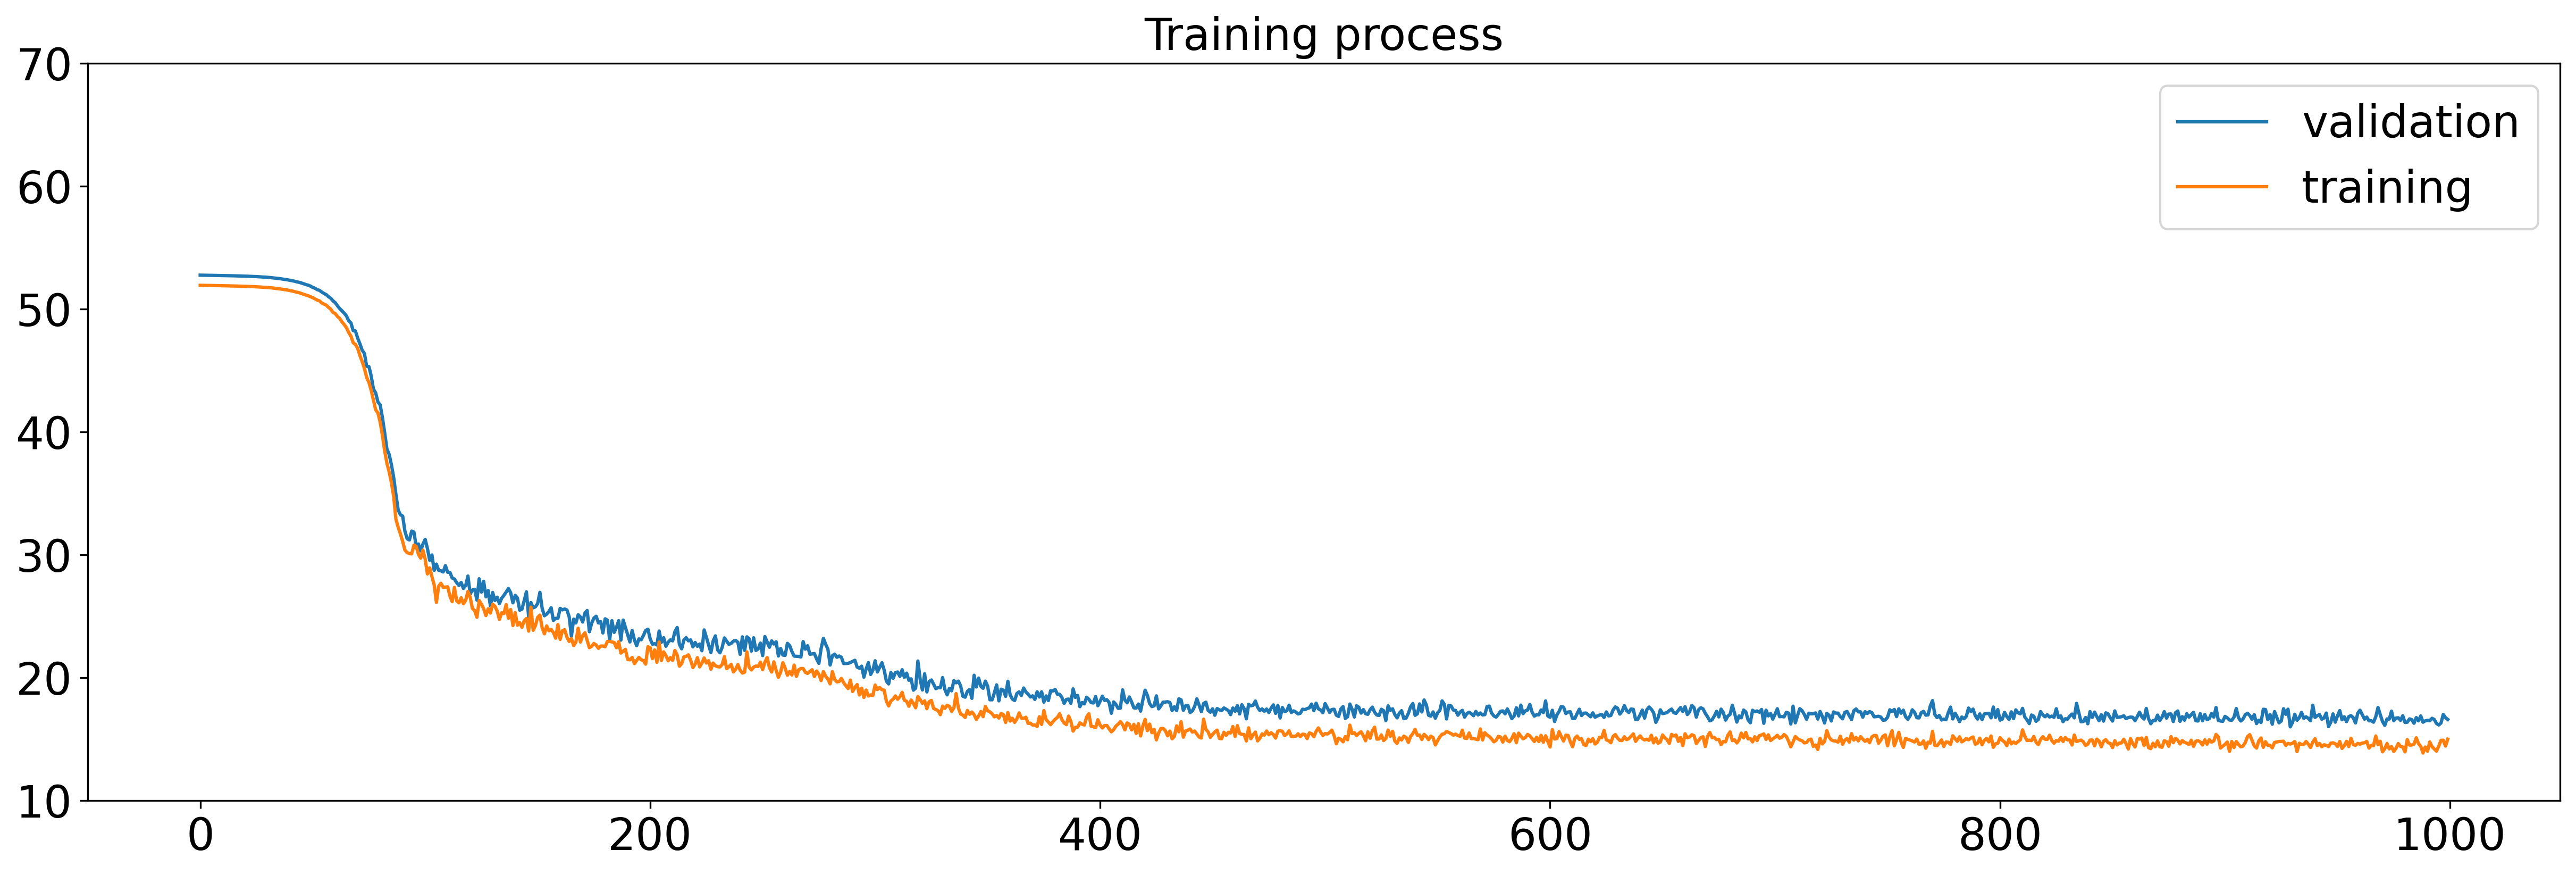

In [68]:
fig, ax = plt.subplots(figsize=(20, 6), dpi=300)
plt.plot(val_loss_list_rmse[0:1000], label='validation')
plt.plot(train_loss_list_rmse[0:1000], label='training')
plt.legend(fontsize=20)
plt.ylim((10, 70))
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)
plt.title('Training process', fontsize=20)
plt.savefig(r'./Figures/loss_rmse.png', dpi = 300)

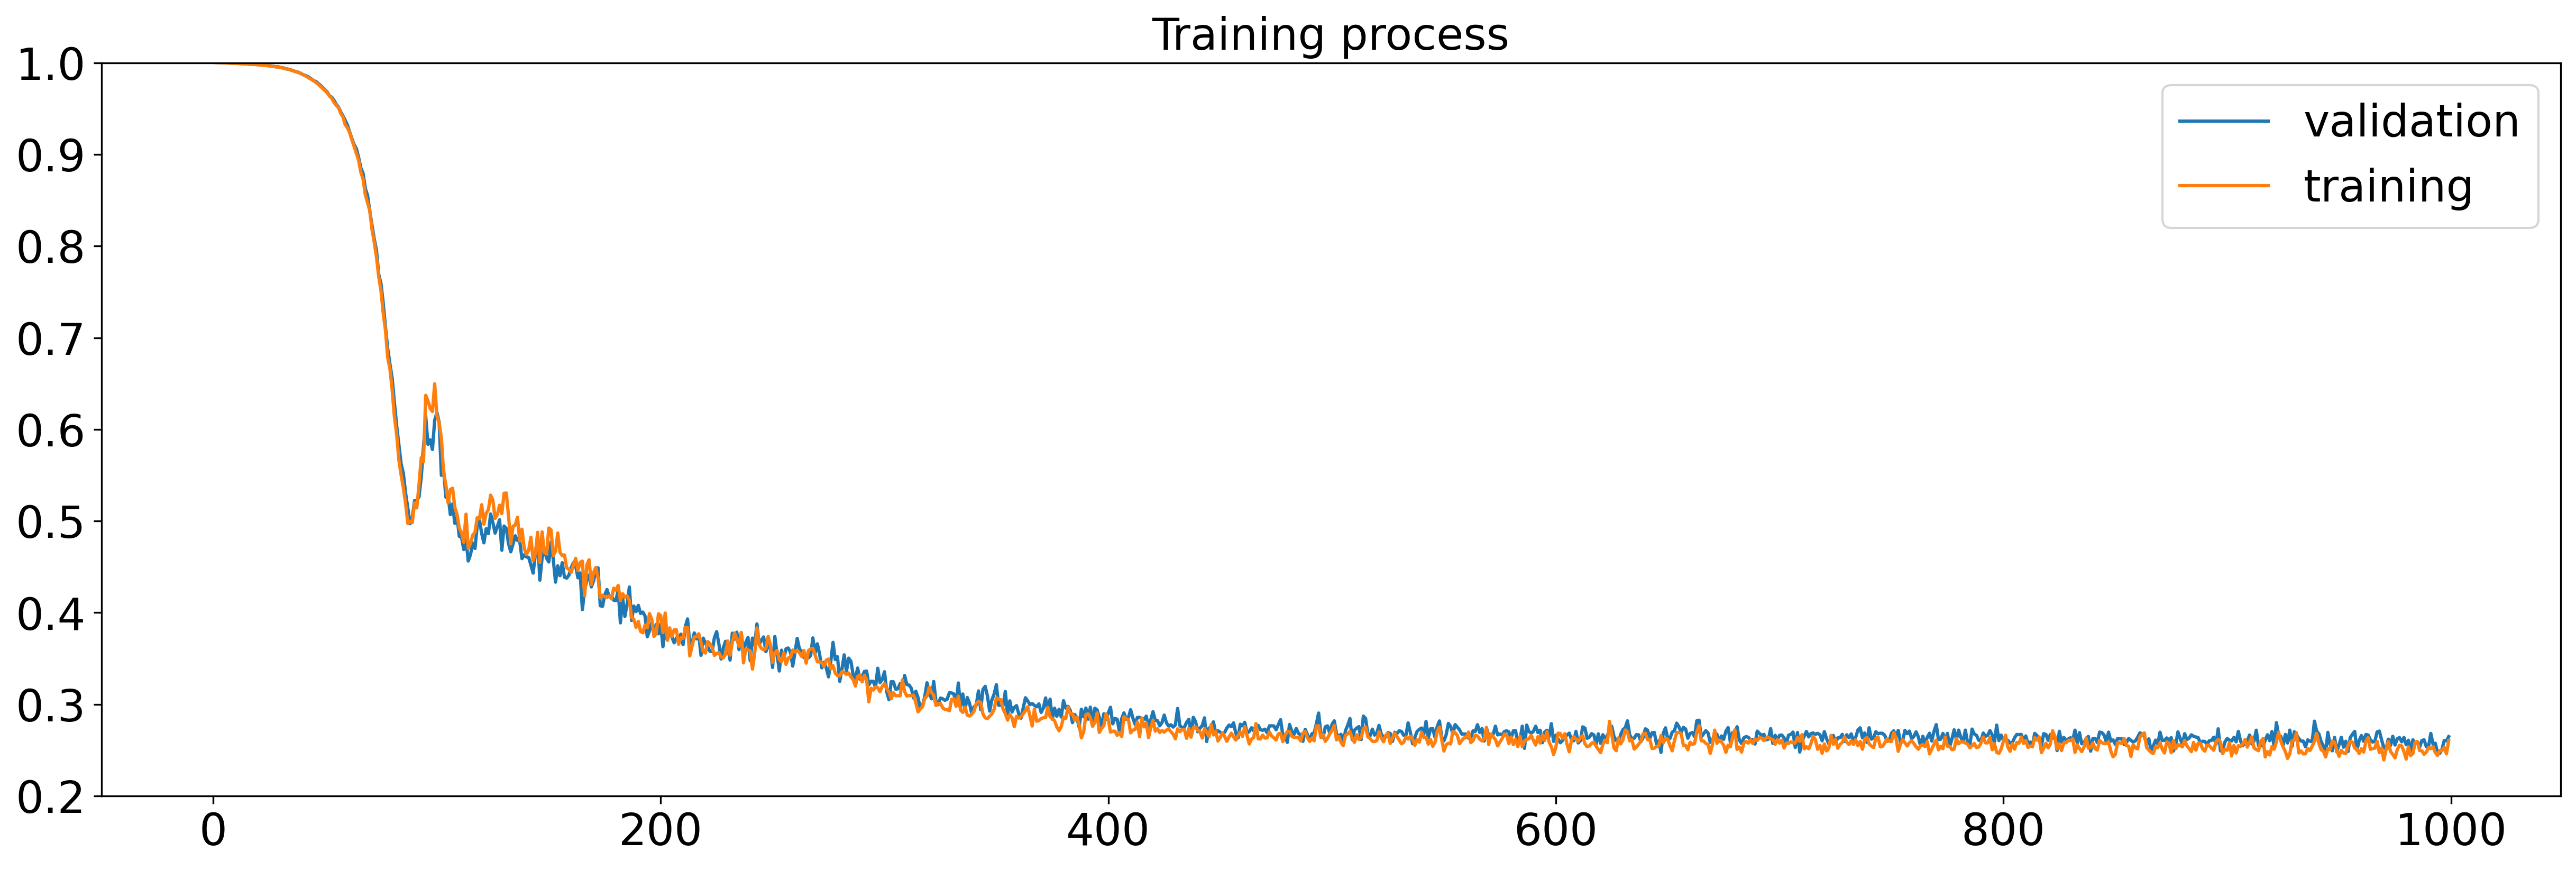

In [69]:
fig, ax = plt.subplots(figsize=(20, 6), dpi=300)
plt.plot(val_loss_list[0:1000], label='validation')
plt.plot(train_loss_list[0:1000], label='training')
plt.legend(fontsize=20)
plt.ylim((0.2,1))
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)
plt.title('Training process', fontsize=20)
plt.savefig(r'./Figures/loss_percentage.png', dpi = 300)

In [70]:
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GCNConv
from sklearn import metrics
from math import sqrt
import random
device = torch.device('cuda')

model = Net_LSTM(time_number=12)
model.to(device)

learning_rate = 0.001
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
X_Speed = X_Speed.float().to(device)
network.to(device)
# Training
# eva = 'rmse'
# k_folder_Train(10, 300, True_list,network,X_Speed, eva)
epoch = 2000
val_loss_list = []
train_loss_list = []

val_loss_list_rmse = []
train_loss_list_rmse = []

model_loss = 1000000

for e in range(epoch):
    out = model(network, X_Speed)[:, :]
    y = network.y[:, :]
    optimizer.zero_grad()  
#     print(out-y)
    loss = torch.sqrt(loss_function(out[Train_Mask], y[Train_Mask]).float())
#     loss = my_loss(out[Train_Mask], y[Train_Mask]).float()
#     print(loss)
    
    loss.backward()
    optimizer.step()
    
#     loss_val = loss_function(out[Val_Mask], y[Val_Mask])
    loss_val = my_loss(out[Val_Mask], y[Val_Mask])
    loss_train = my_loss(out[Train_Mask], y[Train_Mask])
    
    loss_train_rmse = torch.sqrt(loss_function(out[Train_Mask], y[Train_Mask]).float())
    loss_val_rmse = torch.sqrt(loss_function(out[Val_Mask], y[Val_Mask].float()))
    
#     print('training error is: ', loss)
    val_loss_list.append(loss_val.cpu().detach().numpy())
    train_loss_list.append(loss_train.cpu().detach().numpy())
    
    val_loss_list_rmse.append(loss_val_rmse.cpu().detach().numpy())
    train_loss_list_rmse.append(loss_train_rmse.cpu().detach().numpy())
    
    if loss_val.cpu().detach().numpy() < model_loss:
        model_loss = loss_val.cpu().detach().numpy()
        name = 'model_best.pt'
        save_path = os.path.join(r'./LSTM_Model_Weights', name)
        torch.save(model.state_dict(), save_path)
    if e%500 == 0:
        name = 'model_e_' + str(e) + '.pt'
        save_path = os.path.join(r'./LSTM_Models', name)
        torch.save(model.state_dict(), save_path)
        
    print("*****************************************************************")
    print('Epoch: ', e, '    train_loss_percentage:', loss_train.cpu().detach().numpy(), ';    ', 'val_loss_percentage:', loss_val.cpu().detach().numpy())
#     print('val_loss_percentage:', loss_val.cpu().detach().numpy())

*****************************************************************
Epoch:  0     train_loss_percentage: 1.0001644 ;     val_loss_percentage: 1.0001489
*****************************************************************
Epoch:  1     train_loss_percentage: 1.0000203 ;     val_loss_percentage: 1.0000228
*****************************************************************
Epoch:  2     train_loss_percentage: 0.99990183 ;     val_loss_percentage: 0.99992
*****************************************************************
Epoch:  3     train_loss_percentage: 0.9997518 ;     val_loss_percentage: 0.9997449
*****************************************************************
Epoch:  4     train_loss_percentage: 0.9996401 ;     val_loss_percentage: 0.99964994
*****************************************************************
Epoch:  5     train_loss_percentage: 0.99951875 ;     val_loss_percentage: 0.99954385
*****************************************************************
Epoch:  6     train_loss_percent

*****************************************************************
Epoch:  63     train_loss_percentage: 0.89324206 ;     val_loss_percentage: 0.89873123
*****************************************************************
Epoch:  64     train_loss_percentage: 0.8864072 ;     val_loss_percentage: 0.89175487
*****************************************************************
Epoch:  65     train_loss_percentage: 0.88265806 ;     val_loss_percentage: 0.8870474
*****************************************************************
Epoch:  66     train_loss_percentage: 0.87410057 ;     val_loss_percentage: 0.87860096
*****************************************************************
Epoch:  67     train_loss_percentage: 0.86528903 ;     val_loss_percentage: 0.8697209
*****************************************************************
Epoch:  68     train_loss_percentage: 0.8613836 ;     val_loss_percentage: 0.8660421
*****************************************************************
Epoch:  69     train_

*****************************************************************
Epoch:  126     train_loss_percentage: 0.52258325 ;     val_loss_percentage: 0.4971632
*****************************************************************
Epoch:  127     train_loss_percentage: 0.52813554 ;     val_loss_percentage: 0.5036124
*****************************************************************
Epoch:  128     train_loss_percentage: 0.53018165 ;     val_loss_percentage: 0.5098643
*****************************************************************
Epoch:  129     train_loss_percentage: 0.55540276 ;     val_loss_percentage: 0.51286656
*****************************************************************
Epoch:  130     train_loss_percentage: 0.55292684 ;     val_loss_percentage: 0.50809264
*****************************************************************
Epoch:  131     train_loss_percentage: 0.55411416 ;     val_loss_percentage: 0.52500856
*****************************************************************
Epoch:  132  

*****************************************************************
Epoch:  183     train_loss_percentage: 0.5308593 ;     val_loss_percentage: 0.5046193
*****************************************************************
Epoch:  184     train_loss_percentage: 0.532978 ;     val_loss_percentage: 0.50625
*****************************************************************
Epoch:  185     train_loss_percentage: 0.5286028 ;     val_loss_percentage: 0.50764304
*****************************************************************
Epoch:  186     train_loss_percentage: 0.53141046 ;     val_loss_percentage: 0.49158275
*****************************************************************
Epoch:  187     train_loss_percentage: 0.5276827 ;     val_loss_percentage: 0.50334567
*****************************************************************
Epoch:  188     train_loss_percentage: 0.54683536 ;     val_loss_percentage: 0.50448835
*****************************************************************
Epoch:  189     tra

*****************************************************************
Epoch:  240     train_loss_percentage: 0.52956796 ;     val_loss_percentage: 0.5045641
*****************************************************************
Epoch:  241     train_loss_percentage: 0.54763466 ;     val_loss_percentage: 0.50590795
*****************************************************************
Epoch:  242     train_loss_percentage: 0.5426897 ;     val_loss_percentage: 0.499025
*****************************************************************
Epoch:  243     train_loss_percentage: 0.5368752 ;     val_loss_percentage: 0.48110163
*****************************************************************
Epoch:  244     train_loss_percentage: 0.5342994 ;     val_loss_percentage: 0.50378555
*****************************************************************
Epoch:  245     train_loss_percentage: 0.5396137 ;     val_loss_percentage: 0.48580644
*****************************************************************
Epoch:  246     t

*****************************************************************
Epoch:  297     train_loss_percentage: 0.5363303 ;     val_loss_percentage: 0.51295453
*****************************************************************
Epoch:  298     train_loss_percentage: 0.5369381 ;     val_loss_percentage: 0.51005995
*****************************************************************
Epoch:  299     train_loss_percentage: 0.54827297 ;     val_loss_percentage: 0.48764914
*****************************************************************
Epoch:  300     train_loss_percentage: 0.5292238 ;     val_loss_percentage: 0.4935405
*****************************************************************
Epoch:  301     train_loss_percentage: 0.5325907 ;     val_loss_percentage: 0.511562
*****************************************************************
Epoch:  302     train_loss_percentage: 0.518117 ;     val_loss_percentage: 0.49067974
*****************************************************************
Epoch:  303     tra

*****************************************************************
Epoch:  354     train_loss_percentage: 0.5245497 ;     val_loss_percentage: 0.48247546
*****************************************************************
Epoch:  355     train_loss_percentage: 0.51793975 ;     val_loss_percentage: 0.4934382
*****************************************************************
Epoch:  356     train_loss_percentage: 0.5282085 ;     val_loss_percentage: 0.49121237
*****************************************************************
Epoch:  357     train_loss_percentage: 0.54555964 ;     val_loss_percentage: 0.49024984
*****************************************************************
Epoch:  358     train_loss_percentage: 0.5271932 ;     val_loss_percentage: 0.49980095
*****************************************************************
Epoch:  359     train_loss_percentage: 0.53871775 ;     val_loss_percentage: 0.49517667
*****************************************************************
Epoch:  360   

*****************************************************************
Epoch:  409     train_loss_percentage: 0.523009 ;     val_loss_percentage: 0.5001919
*****************************************************************
Epoch:  410     train_loss_percentage: 0.5002004 ;     val_loss_percentage: 0.47653544
*****************************************************************
Epoch:  411     train_loss_percentage: 0.5429615 ;     val_loss_percentage: 0.49872157
*****************************************************************
Epoch:  412     train_loss_percentage: 0.541839 ;     val_loss_percentage: 0.50169563
*****************************************************************
Epoch:  413     train_loss_percentage: 0.5202088 ;     val_loss_percentage: 0.47813508
*****************************************************************
Epoch:  414     train_loss_percentage: 0.53667367 ;     val_loss_percentage: 0.5162543
*****************************************************************
Epoch:  415     tra

*****************************************************************
Epoch:  464     train_loss_percentage: 0.2888123 ;     val_loss_percentage: 0.288652
*****************************************************************
Epoch:  465     train_loss_percentage: 0.28624648 ;     val_loss_percentage: 0.29513884
*****************************************************************
Epoch:  466     train_loss_percentage: 0.28370813 ;     val_loss_percentage: 0.28231496
*****************************************************************
Epoch:  467     train_loss_percentage: 0.28588754 ;     val_loss_percentage: 0.28545588
*****************************************************************
Epoch:  468     train_loss_percentage: 0.2874163 ;     val_loss_percentage: 0.29379103
*****************************************************************
Epoch:  469     train_loss_percentage: 0.29789177 ;     val_loss_percentage: 0.2857799
*****************************************************************
Epoch:  470    

*****************************************************************
Epoch:  521     train_loss_percentage: 0.2656238 ;     val_loss_percentage: 0.27027515
*****************************************************************
Epoch:  522     train_loss_percentage: 0.2581439 ;     val_loss_percentage: 0.26362062
*****************************************************************
Epoch:  523     train_loss_percentage: 0.25955442 ;     val_loss_percentage: 0.26466745
*****************************************************************
Epoch:  524     train_loss_percentage: 0.2683038 ;     val_loss_percentage: 0.2640616
*****************************************************************
Epoch:  525     train_loss_percentage: 0.2649313 ;     val_loss_percentage: 0.27070066
*****************************************************************
Epoch:  526     train_loss_percentage: 0.26282406 ;     val_loss_percentage: 0.2615854
*****************************************************************
Epoch:  527     

*****************************************************************
Epoch:  578     train_loss_percentage: 0.25012356 ;     val_loss_percentage: 0.25656787
*****************************************************************
Epoch:  579     train_loss_percentage: 0.25632948 ;     val_loss_percentage: 0.26110464
*****************************************************************
Epoch:  580     train_loss_percentage: 0.26766214 ;     val_loss_percentage: 0.25867477
*****************************************************************
Epoch:  581     train_loss_percentage: 0.26199764 ;     val_loss_percentage: 0.2707106
*****************************************************************
Epoch:  582     train_loss_percentage: 0.25507158 ;     val_loss_percentage: 0.26589897
*****************************************************************
Epoch:  583     train_loss_percentage: 0.25732708 ;     val_loss_percentage: 0.27254516
*****************************************************************
Epoch:  584

*****************************************************************
Epoch:  635     train_loss_percentage: 0.25686643 ;     val_loss_percentage: 0.25847772
*****************************************************************
Epoch:  636     train_loss_percentage: 0.25626978 ;     val_loss_percentage: 0.26383328
*****************************************************************
Epoch:  637     train_loss_percentage: 0.2601752 ;     val_loss_percentage: 0.2709007
*****************************************************************
Epoch:  638     train_loss_percentage: 0.2555004 ;     val_loss_percentage: 0.25981075
*****************************************************************
Epoch:  639     train_loss_percentage: 0.25545374 ;     val_loss_percentage: 0.25754955
*****************************************************************
Epoch:  640     train_loss_percentage: 0.26175863 ;     val_loss_percentage: 0.25100923
*****************************************************************
Epoch:  641  

*****************************************************************
Epoch:  692     train_loss_percentage: 0.25681317 ;     val_loss_percentage: 0.26387525
*****************************************************************
Epoch:  693     train_loss_percentage: 0.25596067 ;     val_loss_percentage: 0.2614304
*****************************************************************
Epoch:  694     train_loss_percentage: 0.2593997 ;     val_loss_percentage: 0.2603039
*****************************************************************
Epoch:  695     train_loss_percentage: 0.25567964 ;     val_loss_percentage: 0.2597775
*****************************************************************
Epoch:  696     train_loss_percentage: 0.24918538 ;     val_loss_percentage: 0.26642385
*****************************************************************
Epoch:  697     train_loss_percentage: 0.247754 ;     val_loss_percentage: 0.2635108
*****************************************************************
Epoch:  698     t

*****************************************************************
Epoch:  749     train_loss_percentage: 0.24784353 ;     val_loss_percentage: 0.25599357
*****************************************************************
Epoch:  750     train_loss_percentage: 0.26623684 ;     val_loss_percentage: 0.26941958
*****************************************************************
Epoch:  751     train_loss_percentage: 0.2620635 ;     val_loss_percentage: 0.26725584
*****************************************************************
Epoch:  752     train_loss_percentage: 0.2646795 ;     val_loss_percentage: 0.27171835
*****************************************************************
Epoch:  753     train_loss_percentage: 0.24865043 ;     val_loss_percentage: 0.25854886
*****************************************************************
Epoch:  754     train_loss_percentage: 0.25283444 ;     val_loss_percentage: 0.25097647
*****************************************************************
Epoch:  755 

*****************************************************************
Epoch:  806     train_loss_percentage: 0.25105795 ;     val_loss_percentage: 0.25974298
*****************************************************************
Epoch:  807     train_loss_percentage: 0.25610638 ;     val_loss_percentage: 0.25802946
*****************************************************************
Epoch:  808     train_loss_percentage: 0.2481644 ;     val_loss_percentage: 0.26020065
*****************************************************************
Epoch:  809     train_loss_percentage: 0.24924943 ;     val_loss_percentage: 0.25868416
*****************************************************************
Epoch:  810     train_loss_percentage: 0.2548242 ;     val_loss_percentage: 0.2573995
*****************************************************************
Epoch:  811     train_loss_percentage: 0.25403193 ;     val_loss_percentage: 0.27275693
*****************************************************************
Epoch:  812  

*****************************************************************
Epoch:  866     train_loss_percentage: 0.2526635 ;     val_loss_percentage: 0.25185323
*****************************************************************
Epoch:  867     train_loss_percentage: 0.24522884 ;     val_loss_percentage: 0.25128606
*****************************************************************
Epoch:  868     train_loss_percentage: 0.25367144 ;     val_loss_percentage: 0.26963803
*****************************************************************
Epoch:  869     train_loss_percentage: 0.250931 ;     val_loss_percentage: 0.25276804
*****************************************************************
Epoch:  870     train_loss_percentage: 0.25773636 ;     val_loss_percentage: 0.25032297
*****************************************************************
Epoch:  871     train_loss_percentage: 0.2574774 ;     val_loss_percentage: 0.27186313
*****************************************************************
Epoch:  872   

*****************************************************************
Epoch:  924     train_loss_percentage: 0.24932651 ;     val_loss_percentage: 0.25964206
*****************************************************************
Epoch:  925     train_loss_percentage: 0.2514084 ;     val_loss_percentage: 0.25271407
*****************************************************************
Epoch:  926     train_loss_percentage: 0.26453218 ;     val_loss_percentage: 0.26407892
*****************************************************************
Epoch:  927     train_loss_percentage: 0.26294824 ;     val_loss_percentage: 0.25344825
*****************************************************************
Epoch:  928     train_loss_percentage: 0.25643086 ;     val_loss_percentage: 0.26377174
*****************************************************************
Epoch:  929     train_loss_percentage: 0.25777927 ;     val_loss_percentage: 0.2499622
*****************************************************************
Epoch:  930 

*****************************************************************
Epoch:  982     train_loss_percentage: 0.25219423 ;     val_loss_percentage: 0.25803322
*****************************************************************
Epoch:  983     train_loss_percentage: 0.23992032 ;     val_loss_percentage: 0.26084352
*****************************************************************
Epoch:  984     train_loss_percentage: 0.25241056 ;     val_loss_percentage: 0.2585517
*****************************************************************
Epoch:  985     train_loss_percentage: 0.2609256 ;     val_loss_percentage: 0.26645473
*****************************************************************
Epoch:  986     train_loss_percentage: 0.27559817 ;     val_loss_percentage: 0.25457025
*****************************************************************
Epoch:  987     train_loss_percentage: 0.24810384 ;     val_loss_percentage: 0.2590112
*****************************************************************
Epoch:  988  

*****************************************************************
Epoch:  1040     train_loss_percentage: 0.24652697 ;     val_loss_percentage: 0.25588965
*****************************************************************
Epoch:  1041     train_loss_percentage: 0.25150427 ;     val_loss_percentage: 0.24293113
*****************************************************************
Epoch:  1042     train_loss_percentage: 0.2515135 ;     val_loss_percentage: 0.26573414
*****************************************************************
Epoch:  1043     train_loss_percentage: 0.25575924 ;     val_loss_percentage: 0.2509766
*****************************************************************
Epoch:  1044     train_loss_percentage: 0.2656126 ;     val_loss_percentage: 0.25277704
*****************************************************************
Epoch:  1045     train_loss_percentage: 0.2551836 ;     val_loss_percentage: 0.25280273
*****************************************************************
Epoch:  

*****************************************************************
Epoch:  1098     train_loss_percentage: 0.25879323 ;     val_loss_percentage: 0.2509599
*****************************************************************
Epoch:  1099     train_loss_percentage: 0.25413224 ;     val_loss_percentage: 0.26290104
*****************************************************************
Epoch:  1100     train_loss_percentage: 0.25382447 ;     val_loss_percentage: 0.25178823
*****************************************************************
Epoch:  1101     train_loss_percentage: 0.24358971 ;     val_loss_percentage: 0.24744144
*****************************************************************
Epoch:  1102     train_loss_percentage: 0.25454038 ;     val_loss_percentage: 0.2615777
*****************************************************************
Epoch:  1103     train_loss_percentage: 0.24511018 ;     val_loss_percentage: 0.26069677
*****************************************************************
Epoch:

*****************************************************************
Epoch:  1170     train_loss_percentage: 0.24385624 ;     val_loss_percentage: 0.24904628
*****************************************************************
Epoch:  1171     train_loss_percentage: 0.23992576 ;     val_loss_percentage: 0.24823514
*****************************************************************
Epoch:  1172     train_loss_percentage: 0.24805133 ;     val_loss_percentage: 0.2624823
*****************************************************************
Epoch:  1173     train_loss_percentage: 0.25495774 ;     val_loss_percentage: 0.25723404
*****************************************************************
Epoch:  1174     train_loss_percentage: 0.25027663 ;     val_loss_percentage: 0.25926155
*****************************************************************
Epoch:  1175     train_loss_percentage: 0.2493218 ;     val_loss_percentage: 0.26166195
*****************************************************************
Epoch:

*****************************************************************
Epoch:  1227     train_loss_percentage: 0.26449585 ;     val_loss_percentage: 0.26642588
*****************************************************************
Epoch:  1228     train_loss_percentage: 0.25339293 ;     val_loss_percentage: 0.25411224
*****************************************************************
Epoch:  1229     train_loss_percentage: 0.24480057 ;     val_loss_percentage: 0.24843666
*****************************************************************
Epoch:  1230     train_loss_percentage: 0.24450056 ;     val_loss_percentage: 0.2530713
*****************************************************************
Epoch:  1231     train_loss_percentage: 0.24517134 ;     val_loss_percentage: 0.25848645
*****************************************************************
Epoch:  1232     train_loss_percentage: 0.24269553 ;     val_loss_percentage: 0.25029323
*****************************************************************
Epoch

*****************************************************************
Epoch:  1281     train_loss_percentage: 0.24075593 ;     val_loss_percentage: 0.26492703
*****************************************************************
Epoch:  1282     train_loss_percentage: 0.24328412 ;     val_loss_percentage: 0.25278214
*****************************************************************
Epoch:  1283     train_loss_percentage: 0.25308046 ;     val_loss_percentage: 0.2599652
*****************************************************************
Epoch:  1284     train_loss_percentage: 0.25984302 ;     val_loss_percentage: 0.24411114
*****************************************************************
Epoch:  1285     train_loss_percentage: 0.24217913 ;     val_loss_percentage: 0.2566396
*****************************************************************
Epoch:  1286     train_loss_percentage: 0.24634749 ;     val_loss_percentage: 0.2562433
*****************************************************************
Epoch: 

*****************************************************************
Epoch:  1336     train_loss_percentage: 0.25317225 ;     val_loss_percentage: 0.25891247
*****************************************************************
Epoch:  1337     train_loss_percentage: 0.24314484 ;     val_loss_percentage: 0.24866286
*****************************************************************
Epoch:  1338     train_loss_percentage: 0.2424938 ;     val_loss_percentage: 0.24480149
*****************************************************************
Epoch:  1339     train_loss_percentage: 0.24301615 ;     val_loss_percentage: 0.26145223
*****************************************************************
Epoch:  1340     train_loss_percentage: 0.24591884 ;     val_loss_percentage: 0.25234917
*****************************************************************
Epoch:  1341     train_loss_percentage: 0.24339928 ;     val_loss_percentage: 0.2550611
*****************************************************************
Epoch:

*****************************************************************
Epoch:  1394     train_loss_percentage: 0.25576112 ;     val_loss_percentage: 0.2635135
*****************************************************************
Epoch:  1395     train_loss_percentage: 0.2466605 ;     val_loss_percentage: 0.2501444
*****************************************************************
Epoch:  1396     train_loss_percentage: 0.24138443 ;     val_loss_percentage: 0.24816722
*****************************************************************
Epoch:  1397     train_loss_percentage: 0.24858664 ;     val_loss_percentage: 0.25879452
*****************************************************************
Epoch:  1398     train_loss_percentage: 0.24205424 ;     val_loss_percentage: 0.24838212
*****************************************************************
Epoch:  1399     train_loss_percentage: 0.24135147 ;     val_loss_percentage: 0.25894496
*****************************************************************
Epoch: 

*****************************************************************
Epoch:  1448     train_loss_percentage: 0.24009852 ;     val_loss_percentage: 0.2535412
*****************************************************************
Epoch:  1449     train_loss_percentage: 0.23757406 ;     val_loss_percentage: 0.2540883
*****************************************************************
Epoch:  1450     train_loss_percentage: 0.25457612 ;     val_loss_percentage: 0.2551978
*****************************************************************
Epoch:  1451     train_loss_percentage: 0.25083554 ;     val_loss_percentage: 0.2458759
*****************************************************************
Epoch:  1452     train_loss_percentage: 0.25607425 ;     val_loss_percentage: 0.26378205
*****************************************************************
Epoch:  1453     train_loss_percentage: 0.25740442 ;     val_loss_percentage: 0.25763205
*****************************************************************
Epoch:  

*****************************************************************
Epoch:  1505     train_loss_percentage: 0.24239632 ;     val_loss_percentage: 0.2514725
*****************************************************************
Epoch:  1506     train_loss_percentage: 0.24653809 ;     val_loss_percentage: 0.25762
*****************************************************************
Epoch:  1507     train_loss_percentage: 0.2479424 ;     val_loss_percentage: 0.24718536
*****************************************************************
Epoch:  1508     train_loss_percentage: 0.24352007 ;     val_loss_percentage: 0.24576424
*****************************************************************
Epoch:  1509     train_loss_percentage: 0.24519484 ;     val_loss_percentage: 0.25252482
*****************************************************************
Epoch:  1510     train_loss_percentage: 0.23703273 ;     val_loss_percentage: 0.24841624
*****************************************************************
Epoch:  1

*****************************************************************
Epoch:  1562     train_loss_percentage: 0.24281874 ;     val_loss_percentage: 0.2512367
*****************************************************************
Epoch:  1563     train_loss_percentage: 0.2386981 ;     val_loss_percentage: 0.25201473
*****************************************************************
Epoch:  1564     train_loss_percentage: 0.24446405 ;     val_loss_percentage: 0.23427495
*****************************************************************
Epoch:  1565     train_loss_percentage: 0.24575803 ;     val_loss_percentage: 0.2583838
*****************************************************************
Epoch:  1566     train_loss_percentage: 0.24937132 ;     val_loss_percentage: 0.2505011
*****************************************************************
Epoch:  1567     train_loss_percentage: 0.2479239 ;     val_loss_percentage: 0.26048437
*****************************************************************
Epoch:  1

*****************************************************************
Epoch:  1618     train_loss_percentage: 0.24505767 ;     val_loss_percentage: 0.25340015
*****************************************************************
Epoch:  1619     train_loss_percentage: 0.24391618 ;     val_loss_percentage: 0.24862508
*****************************************************************
Epoch:  1620     train_loss_percentage: 0.24378528 ;     val_loss_percentage: 0.25324446
*****************************************************************
Epoch:  1621     train_loss_percentage: 0.24230617 ;     val_loss_percentage: 0.25325945
*****************************************************************
Epoch:  1622     train_loss_percentage: 0.2476297 ;     val_loss_percentage: 0.24809949
*****************************************************************
Epoch:  1623     train_loss_percentage: 0.24744152 ;     val_loss_percentage: 0.24778043
*****************************************************************
Epoch

*****************************************************************
Epoch:  1674     train_loss_percentage: 0.23689209 ;     val_loss_percentage: 0.23449042
*****************************************************************
Epoch:  1675     train_loss_percentage: 0.24724565 ;     val_loss_percentage: 0.24482808
*****************************************************************
Epoch:  1676     train_loss_percentage: 0.25545433 ;     val_loss_percentage: 0.25217813
*****************************************************************
Epoch:  1677     train_loss_percentage: 0.24839188 ;     val_loss_percentage: 0.24658498
*****************************************************************
Epoch:  1678     train_loss_percentage: 0.23828872 ;     val_loss_percentage: 0.24419472
*****************************************************************
Epoch:  1679     train_loss_percentage: 0.24916579 ;     val_loss_percentage: 0.2480854
*****************************************************************
Epoch

*****************************************************************
Epoch:  1728     train_loss_percentage: 0.24255924 ;     val_loss_percentage: 0.25670838
*****************************************************************
Epoch:  1729     train_loss_percentage: 0.24977337 ;     val_loss_percentage: 0.24561204
*****************************************************************
Epoch:  1730     train_loss_percentage: 0.246868 ;     val_loss_percentage: 0.24717686
*****************************************************************
Epoch:  1731     train_loss_percentage: 0.24213442 ;     val_loss_percentage: 0.24540484
*****************************************************************
Epoch:  1732     train_loss_percentage: 0.24675809 ;     val_loss_percentage: 0.25305066
*****************************************************************
Epoch:  1733     train_loss_percentage: 0.24536385 ;     val_loss_percentage: 0.245395
*****************************************************************
Epoch:  

*****************************************************************
Epoch:  1785     train_loss_percentage: 0.24307777 ;     val_loss_percentage: 0.26460758
*****************************************************************
Epoch:  1786     train_loss_percentage: 0.2424974 ;     val_loss_percentage: 0.25318637
*****************************************************************
Epoch:  1787     train_loss_percentage: 0.25254652 ;     val_loss_percentage: 0.25079346
*****************************************************************
Epoch:  1788     train_loss_percentage: 0.23988374 ;     val_loss_percentage: 0.25264475
*****************************************************************
Epoch:  1789     train_loss_percentage: 0.23764502 ;     val_loss_percentage: 0.26447022
*****************************************************************
Epoch:  1790     train_loss_percentage: 0.24467084 ;     val_loss_percentage: 0.24294303
*****************************************************************
Epoch

*****************************************************************
Epoch:  1840     train_loss_percentage: 0.23839636 ;     val_loss_percentage: 0.258887
*****************************************************************
Epoch:  1841     train_loss_percentage: 0.2366308 ;     val_loss_percentage: 0.24548988
*****************************************************************
Epoch:  1842     train_loss_percentage: 0.24301778 ;     val_loss_percentage: 0.24893606
*****************************************************************
Epoch:  1843     train_loss_percentage: 0.24486239 ;     val_loss_percentage: 0.2478454
*****************************************************************
Epoch:  1844     train_loss_percentage: 0.24687447 ;     val_loss_percentage: 0.2525252
*****************************************************************
Epoch:  1845     train_loss_percentage: 0.2353569 ;     val_loss_percentage: 0.2556139
*****************************************************************
Epoch:  184

*****************************************************************
Epoch:  1898     train_loss_percentage: 0.24721757 ;     val_loss_percentage: 0.24913941
*****************************************************************
Epoch:  1899     train_loss_percentage: 0.23711585 ;     val_loss_percentage: 0.25750118
*****************************************************************
Epoch:  1900     train_loss_percentage: 0.23429006 ;     val_loss_percentage: 0.25303102
*****************************************************************
Epoch:  1901     train_loss_percentage: 0.2358221 ;     val_loss_percentage: 0.2490343
*****************************************************************
Epoch:  1902     train_loss_percentage: 0.23816372 ;     val_loss_percentage: 0.24494337
*****************************************************************
Epoch:  1903     train_loss_percentage: 0.24742648 ;     val_loss_percentage: 0.2485843
*****************************************************************
Epoch: 

*****************************************************************
Epoch:  1958     train_loss_percentage: 0.2391384 ;     val_loss_percentage: 0.25041422
*****************************************************************
Epoch:  1959     train_loss_percentage: 0.23871605 ;     val_loss_percentage: 0.24424133
*****************************************************************
Epoch:  1960     train_loss_percentage: 0.24361648 ;     val_loss_percentage: 0.24155606
*****************************************************************
Epoch:  1961     train_loss_percentage: 0.24780363 ;     val_loss_percentage: 0.24049106
*****************************************************************
Epoch:  1962     train_loss_percentage: 0.23320921 ;     val_loss_percentage: 0.24988805
*****************************************************************
Epoch:  1963     train_loss_percentage: 0.23109111 ;     val_loss_percentage: 0.24634759
*****************************************************************
Epoch

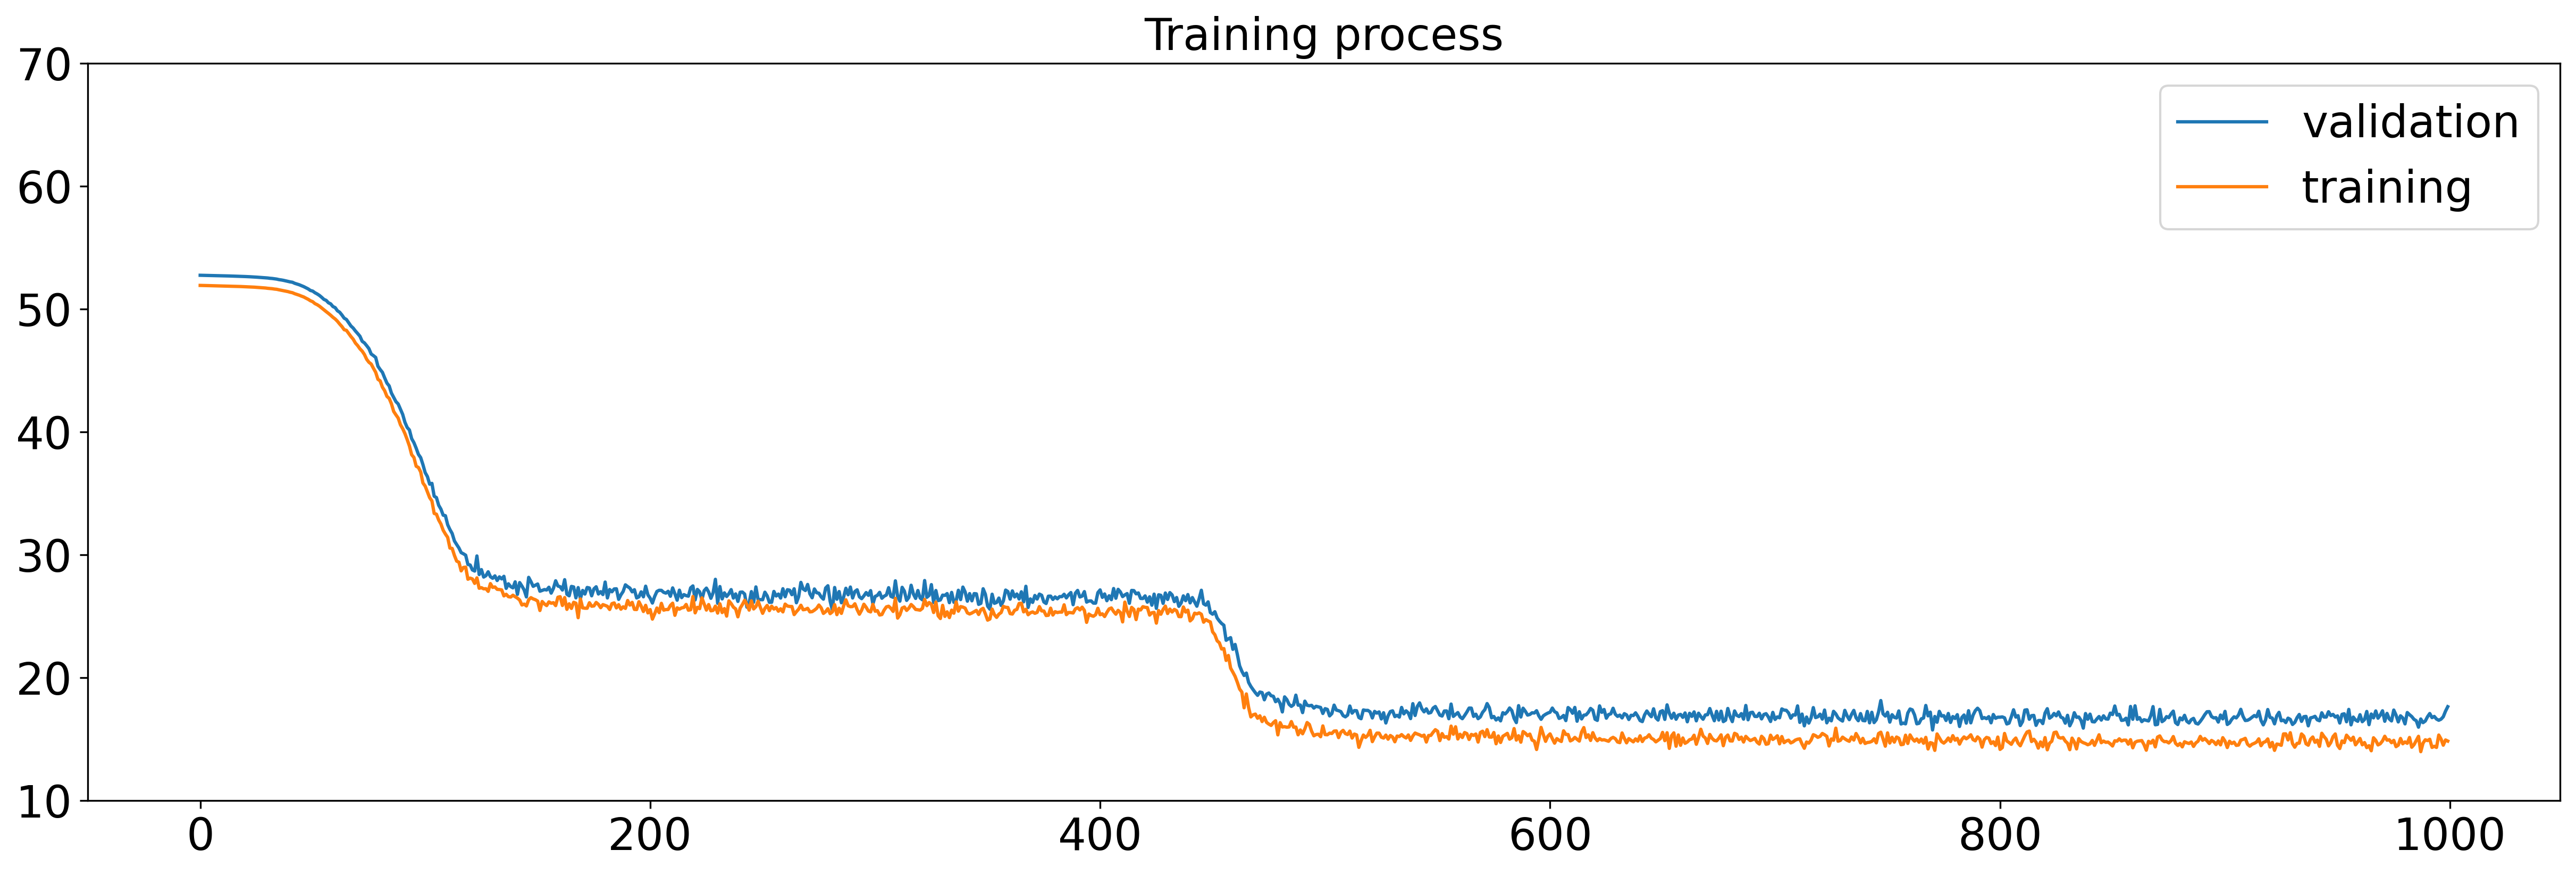

In [71]:
fig, ax = plt.subplots(figsize=(20, 6), dpi=300)
plt.plot(val_loss_list_rmse[0:1000], label='validation')
plt.plot(train_loss_list_rmse[0:1000], label='training')
plt.legend(fontsize=20)
plt.ylim((10, 70))
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)
plt.title('Training process', fontsize=20)
plt.savefig(r'./Figures/noscene_loss_rmse.png', dpi = 300)

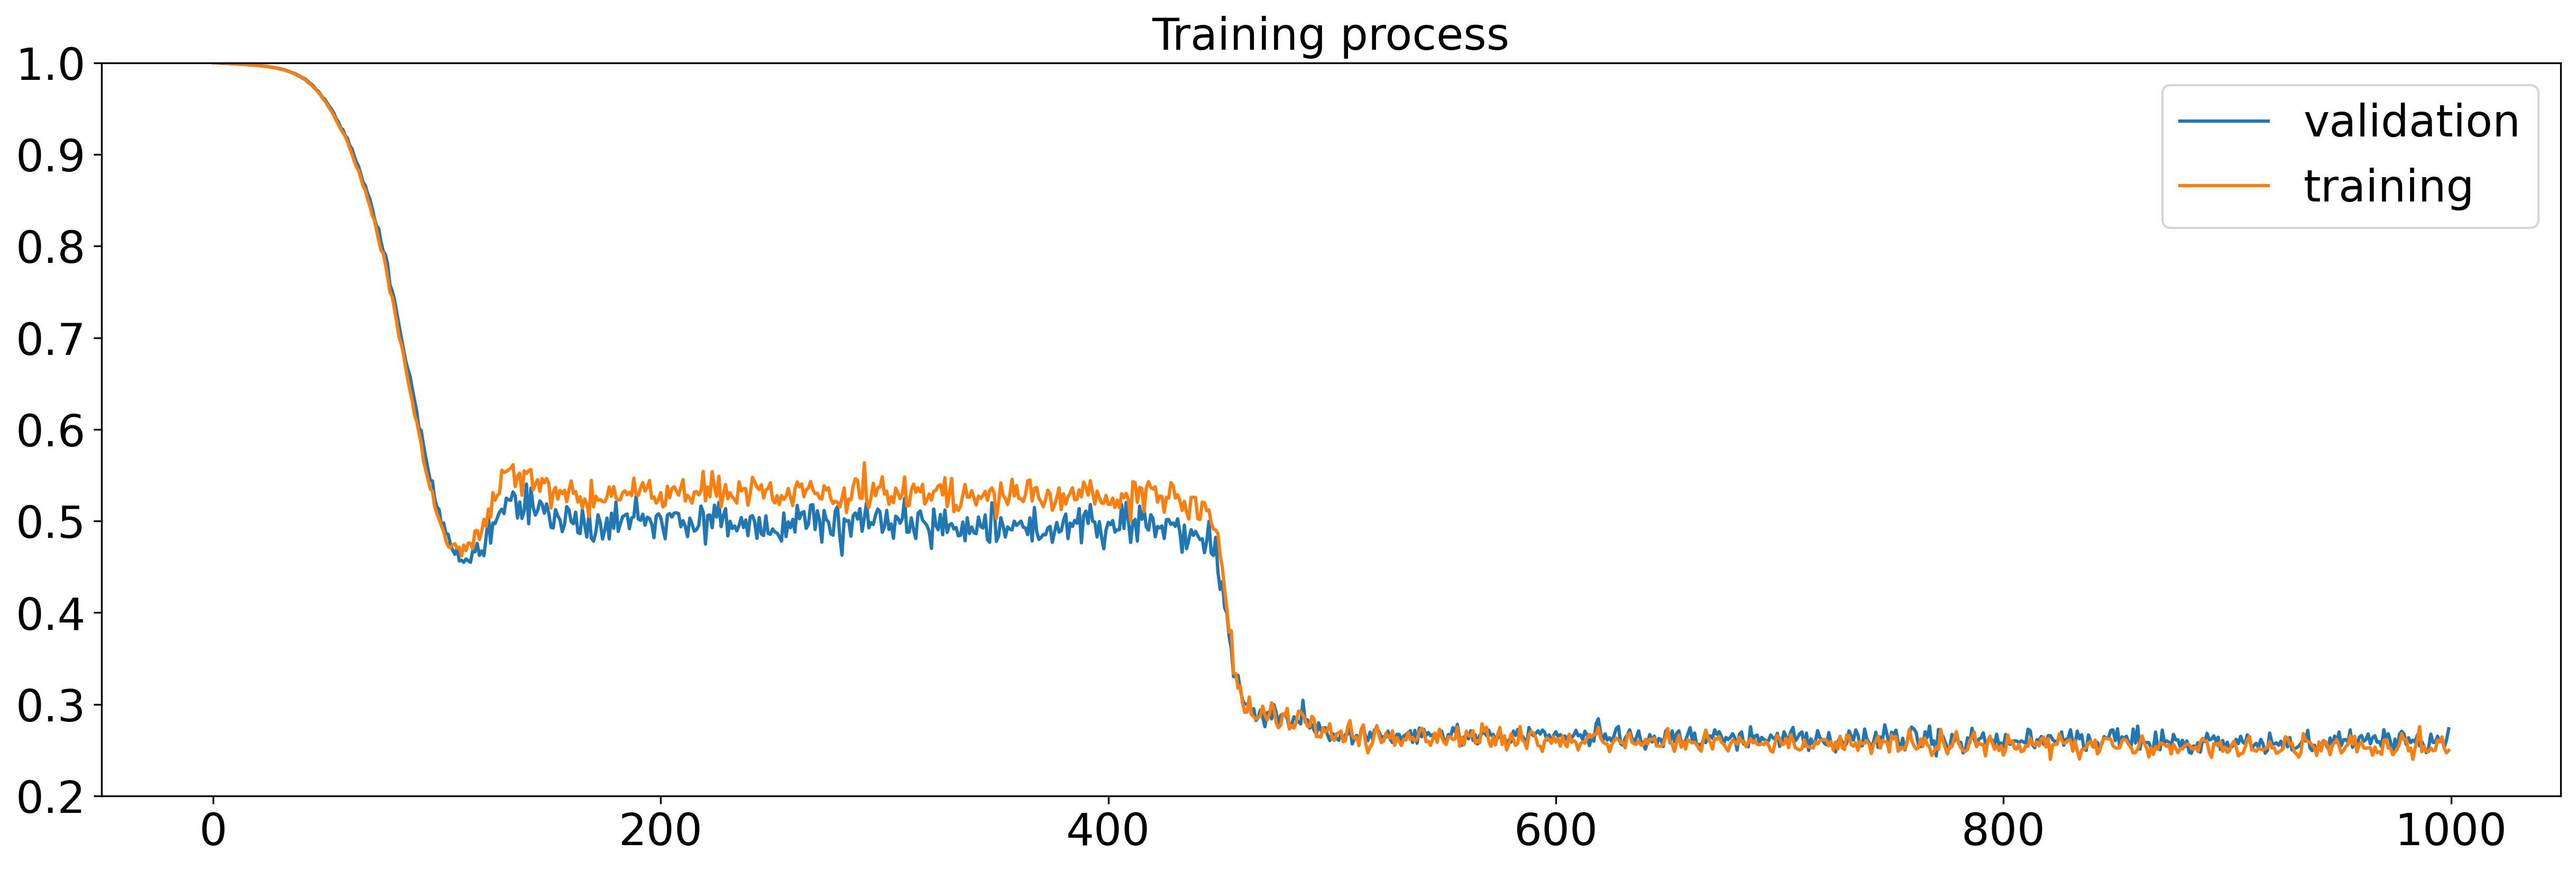

In [72]:
fig, ax = plt.subplots(figsize=(20, 6), dpi=300)
plt.plot(val_loss_list[0:1000], label='validation')
plt.plot(train_loss_list[0:1000], label='training')
plt.legend(fontsize=20)
plt.ylim((0.2,1))
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)
plt.title('Training process', fontsize=20)
plt.savefig(r'./Figures/noscene_loss_percentage.png', dpi = 300)

In [45]:
#Test dataset

In [82]:
best_model = Net_LSTM(time_number=12)
best_model.load_state_dict(torch.load(r'./LSTM_Model_Weights/model_best.pt'))
best_model.to(device)
out = best_model(network, X_Speed)[:, :]
y = network.y[:, :]
p_loss_test = my_loss(out[Test_Mask], y[Test_Mask])
rmse_loss_test = torch.sqrt(loss_function(out[Test_Mask], y[Test_Mask]).float())
print(p_loss_test)
print(rmse_loss_test)

tensor(0.2649, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(15.8431, device='cuda:0', grad_fn=<SqrtBackward0>)


In [83]:
best_model = Net(time_number=12)
best_model.load_state_dict(torch.load(r'./Model_Weights/model_best.pt'))
best_model.to(device)
out = best_model(network, X_Speed)[:, :]
y = network.y[:, :]
p_loss_test = my_loss(out[Test_Mask], y[Test_Mask])
rmse_loss_test = torch.sqrt(loss_function(out[Test_Mask], y[Test_Mask]).float())
print(p_loss_test)
print(rmse_loss_test)

tensor(0.2596, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(16.3555, device='cuda:0', grad_fn=<SqrtBackward0>)
